Numerical methods project
===================
Angelo Davis CID: 01725569
----------------
Run the cells below in order, change the parameters in the parameters cell. I wouldn't run anything in the testing for accuracy + efficiency section because some of these cells have very long runtimes, but if you're interested to see how the unknown functions perform which you're going to put in work, then go ahead...

In [1]:
%pylab inline 
#this imports all of the functions from numpy and matplotlib.pyplot, so you don't need to call the library with np. or plt.
import timeit
plt.rcParams['figure.figsize']=[12,8]
plt.rcParams['figure.dpi'] = 100

Populating the interactive namespace from numpy and matplotlib


Thought process
================
solving: $$\min_{x_{0} \in R} I(x_0)$$ where $$I(x_0) = \int\limits_0^1 (x(t;x_0) - z(t))^2$$

Initially I decided to solve this problem without the differential to the $f(x, t)$ in the ODE but then I changed my mind when I realized that you were going to give the derivative. 

It would have been nice to work with arrays for the whole thing. Applying mathematical functions to arrays will return an array with the function applied to each element in the array. Unfortunately, this is not the case for itterative functions, which meant that I had to use some for loops where I otherwise wouldn't have had to. That said, I did use arrays to simplify the trapesium rule function greatly compared with using for loops.

I did not generalise my code for any integral bounds, instead, all of the functions are written specifically for $ 0 < t < 1$. The way that the integral is carried out is to just take n data points for z(t) and the solution to the ODE, both in arrays then just take one from the other and just add up all of the data points divided by dt using the trapesium rule.

Pseudocode
----------------
I'm gonna go through the code starting with the innder functions working outwards: 

Solving the ODE implicitly:
$$\dot x = f(x, t)$$
This gives the implicit term to term rule using right hand Riemann:
$$x_{n+1} = x_n + f(x_{n+1}, t_n)\times \Delta t$$

Where you have to solve for $x_{n+1}$ using newton's method: $f(x_{n+1}) = x_{n+1} - x_n - f(x_{n+1}, t_n)\times \Delta t = 0$
Firstly, I'm going to change the iteration labels so that the Newton's method doesn't get confusing: $x_n = x_{n+1}, x = x_n$ where $x$ is the previous value of $x$ from the ODE solution, and is constant for each root solving step. 

We also need the differential: ($f'(x, t)$ Is known given an ODE 
)$$f'(x_{n+1}) = 1 - f'(x_{n+1}, t_n)\times \Delta t$$ 
Which gives the term to term iteration for Newton's method:$$x_{n+1} = x_n - \frac{x_n - x - f(x_n, t)\times \Delta t}{1 - f'(x_{n}, t)\times \Delta t}$$

Thus the pseudocode for Newton's method would be:

def NewtonMethod($x_{start}$, $t$, $dt$, tolerance):
<br>$x_n = x_{start}$
<br> While $f(x)$ > tolerance:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$x_{n+1} = x_n - \frac{x_n - x - f(x_n, t)\times \Delta t}{1 - f'(x_{n}, t)\times \Delta t}$
<br>return $x_{n+1}$

And the pseudocode for implicitly approximating an ODE:

def ReverseEuler($x_0, t_0, T, n$):
<br>This is a more general integration that can integrate between the bounds $t_0$ and $T$ but my actual code is designed to work only between $0 < t < 1$.
<br>$dt = \frac{T - t_0}{n}$
<br> x = x_0
<br> for i in range(n):
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$t = t_0 + i\times dt$
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$x$ = NewtonMethod($x, t, dt, $tolerance)
<br> output.append(x)
<br> retun array(output) #converting output into an array to make the trapesium rule step much easier. 

Trapesium rule: <br>So, this method is just dividing your bounds into a number of evenly spaced sections, each approximated by a trapesium where you can evaluate your function at the boundary for each of the sections, find the mean of the two evaluations and multiply that by the size of the boundary in order to find the size of the trapesium. The function is only evaluated at the start and end once each giving: $$0.5 \times \Delta t \times(f(x_0) + f(x_N))$$
Every other term is evaluated twice since you want to find the area of the adjacent trapesiums, hence the factor of $\frac{1}{2}$ cancels: $$\sum_{n = 1}^{N - 1} f(x_n)\times \Delta t $$ Adding the two together gives: $$0.5 \times \Delta t \times(f(x_0) + f(x_N)) + \sum_{n = 1}^{N - 1} f(x_n)\times \Delta t $$ where $N = \frac{x_N}{dt}$
<br>This is effectively what my trapesium rule function looks like, just add all the elements in an array together.

With the above code we have a function of $x_0$ which effectively looks like this: $$I(x_0) = trapesium((ReverseEuler(x_0) - z)^2)$$

Now I have a working function: $I(x_0)$, I need to write a minimisation function that would work by approximating the differential to my function. Instead of using $x_{n+1} = x_n - \lambda\frac{f(x_n + h) - f(x_n)}{h}$ where h is a constant for each iteration, I decided to use a secant line so that the gap between the evaluated points would get closer as the differential approached zero: $$x_{n+1} = x_{n} - \lambda\frac{I(x_n) - I(x_{n-1})}{x_n - x_{n-1}}$$
Pseudocode:
<br>$\frac{dI}{dx_0} = \frac{I(x_n) - I(x_{n-1})}{x_n - x_{n-1}}$
<br>while $|\frac{dI}{dx_0}(x_n, x_{n-1})| > $ tolerance:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$x_{n+1} = x_{n} - \lambda\frac{dI}{dx_0}(x_n, x_{n-1})$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$x_{n-1} = x_n$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$x_n = x_{n+1}$
<br>return $x_n$

Overall, the way my code works is that it returns an approximate solution to the ODE with the same number of data points in the same range as the integral being applied, so all I have to do is add up all the data points and multiply them by dt, which cuts out having to evaluate my function, since I already got all of the values out of it beforehand. Then I just repeat this, varying the starting value of x for each step in the minimisation process until the gradient is roughly equal to zero. 


Code
====

In [2]:
def minimise(x0, x1, fx, lambda_, tolerance):
    """
    Minimises functions which can't be algebraically differentiated using a secant line
    Inputs: x0 and x1 are two starting values for the secant line used to approximate dy/dx
            fx is the function in question
            lambda_ is the step size modifier
            tolerance is the value of dy/dx at which the function will stop
    Output: The x value at which the function is minimised
    """    
    #dfdx = lambda fx, x0, x1: (fx(x1) - fx(x0))/(x1 - x0) #defining gradient of secant line. Obsolete because it evaluates twice
    ddx = 1
    a,b =  fx(x1), fx(x0)
    while abs(ddx) > tolerance:
        ddx = (a - b)/(x1 - x0)#finding the gradient
        x2 = x1 - lambda_*ddx #finding the next term in the iteration using a secant
        a, b = fx(x2), a #This step means that I only need to evaluate the function once per loop, as opposed to twice using dfdx
        x0, x1 = x1, x2 #xold = xn for next loop, xn = xnew for next loop    
    return x2

trapesium = lambda a, dt: 0.5*dt*(a[0]+a[-1]) + sum(a[1:-1])*dt
trapesium.__doc__ = """
Inputs: a: Type 1D array. An array containing descrete points of your function between any bounds
        dt: Type: Float. The stepsize between the descrete points in your function
Output: Type: FLoat. The approximate integral of your function using the trapesium rule.

"""
 
def Newton4Euler(x0, fxt, dfxtdt, t, dt, F):
    """Designed specifically for solving for the next step using the reverse Euler method
    Inputs: x0: Starting value of the ODE at t = 0
            fxt: The function f(x,t) in the ODE where dx/dt = f(x,t)
            dfxtdt: The differential of f(x,t) in the ODE with respect to x
            t: The time at which the next value of x is being solved for
            dt: The stepsize between times t
            F: Just a placeholder to define F before I initialise the while loop which saves on the line count. When I call the
            function, I just put a 1 in the final argument position
    Output: The next value of x(t) in the solution to the ODE using the reverse Euler iteration
    """    
    x1 = x0 - (x0 - x0 - fxt(x0, t)*dt)/(1-dfxtdt(x0, t)*dt) #initalise x1, using the previous value x0 as our starting point
    x1 = x0 #for some reason it's slower doing this than doing the above step 
    while abs(F) > tolerance: #while loop exits when our function of x is close to zero 
        F = x1 - x0 - fxt(x1, t)*dt #defining the top of the fraction in newton's itteration (which is just f(x) that we're solving)
        x1 = x1 - F/(1-dfxtdt(x1, t)*dt) #finding the next term
    return x1 #returns the value of x1 once the loop exits.  

def reverse_euler(x0, fxt, dt, n):
    """
    Takes the value of x (x0) at t=0 and itterates to find the approximate solution to an ODE given by dx/dt = f(x, t)
    between t = 0 and t = 1.
    Inputs: x0: The value of x at t = 0. 
            fxt: This is f(x, t) in dx/dt, 
            dt: The step size, smaller dt increases resolution
    Output: Array containing all of the values of the solutions to the ODE between t = 0 and t = 1
    """
    out = []
    for i in range(n):
        out.append(x0) #append outputs
        x0 = Newton4Euler(x0, fxt, dfdx, i*dt, dt, 1) #the next value in the iteration is just the newton's method root
    #[out.append(Newton4Euler(out[-1], fxt, dfdx, i*dt, dt, 1)) for i in range(n-1)] #did it in one line but was slower...
    return array(out)
    
#reverse_euler = lambda x, fxt, dt, n: (lambda a, fxt, dt, n, : ([a.append(Newton4Euler(a[-1], fxt, dfdx, i*dt, dt, 1)) for i in range(n-1)], array(a)))([x], fxt, dt, n)[1]
"""Above is the reverse euler function in one line, I left in the multiline version so that it's readable, also because
the multiline version is faster, because it didn't take the overhead of defining a function within a function to get it to work"""


"Above is the reverse euler function in one line, I left in the multiline version so that it's readable, also because\nthe multiline version is faster, because it didn't take the overhead of defining a function within a function to get it to work"

Run the parameters cell below to get your solution
---------------------

In [3]:
T = 1
n = 20000
dt = T/n
t = linspace(0,T,n)
tolerance = 1e-6
lambda_ = 0.1

zt = lambda t: t**2 #defining z(t) so that I can test my code
fxt = lambda x, t: e**(t) #defining f(x, t) in dx/dt = f(x, t) so that I can test my code 
dfdx = lambda x, t: 0 #defining the differential of f(x,t) in in the ODE

start = timeit.default_timer() #starting the timer
print("Solution = " + str(minimise(1,1.1, lambda x: trapesium((reverse_euler(x, fxt, dt, n)-zt(t))**2, dt), lambda_, tolerance))) #running all of my functions
print("Time = " + str(timeit.default_timer() - start)+ " s") #calculating the runtime

Solution = -0.38488022084764073
Time = 2.6324138 s


Testing the functions for accuracy + efficiency
------
I used the functions $\dot x = xt$ and $z(t) = x^2$ as my test case for my solution. Lamda = 0.1 in all cases. This lambda value is ideal for my test cases because it doesn't end up oscillating about the minimum point, as the gradient descent does with lambda = 1. Lambda = 0.2 actually runs faster for this specific test case because it gets to the minimum faster without oscillation, but this will vary depending on the steepness of the curve for each test case so I settled with 0.1 so that it will work with steeper curves.

In [4]:
import timeit
def n_iterations(start, end, stepsize):
    """This function returns a two lists one of time taken for each individual iteration, and the other is the value of the 
    approximate solution against n iterations for the integral / ODE
    Inputs: start: starting number of iterations to probe
            end: maximum number of iterations to probe
            stepsize: stepsize
    Output: 3 lists, containing number of iterations against the corresponding solution and the time taken to get that solution"""
    out = [[],[],[]]
    for i in range(start, end, stepsize):
        T = 1
        dt = T/i
        n = i
        t = linspace(0,T,n)
        out[0].append(i)
        start = timeit.default_timer()
        out[2].append(minimise(1,1.1, lambda x: trapesium((reverse_euler(x, fxt, dt, n)-zt(t))**2, dt), 0.1, tolerance))
        end = timeit.default_timer()
        out[1].append(end - start)
    return out[0], out[1], out[2]
x,z,y = n_iterations(100, 2000, 50)
print("Done\nRuntime = " + str(sum(z)) + " s")

Done
Runtime = 5.232904500000007 s


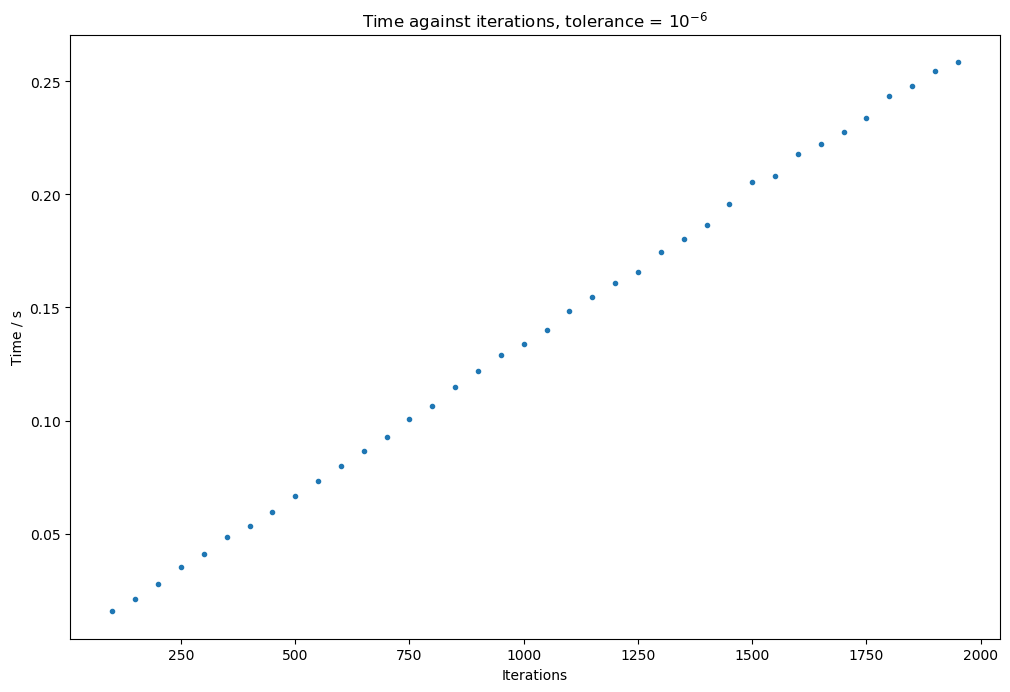

In [5]:
title("Time against iterations, tolerance = $10^{-6}$")
ylabel("Time / s")
xlabel("Iterations")
plot(x, z, linestyle = " ", marker = ".")

Having a linear relationship between iterations and execution time is a good sign for the complexity of the code being $n^1$. This makes sense looking at the code, since the slowest step is the solution to the ODE, which also has uses Newton's method to find a root for each step. The root finding should always take about the same amount of time, the minimise function should always take the same number of iterations, regardless of the value of n, and so the total number of times that Newton's method is run is just n times, then times the number of iterations required by the minimiser.

This linear relationship means that I can do a very high number of iterations without a huge runtime, and it also makes the runtime predictible. 

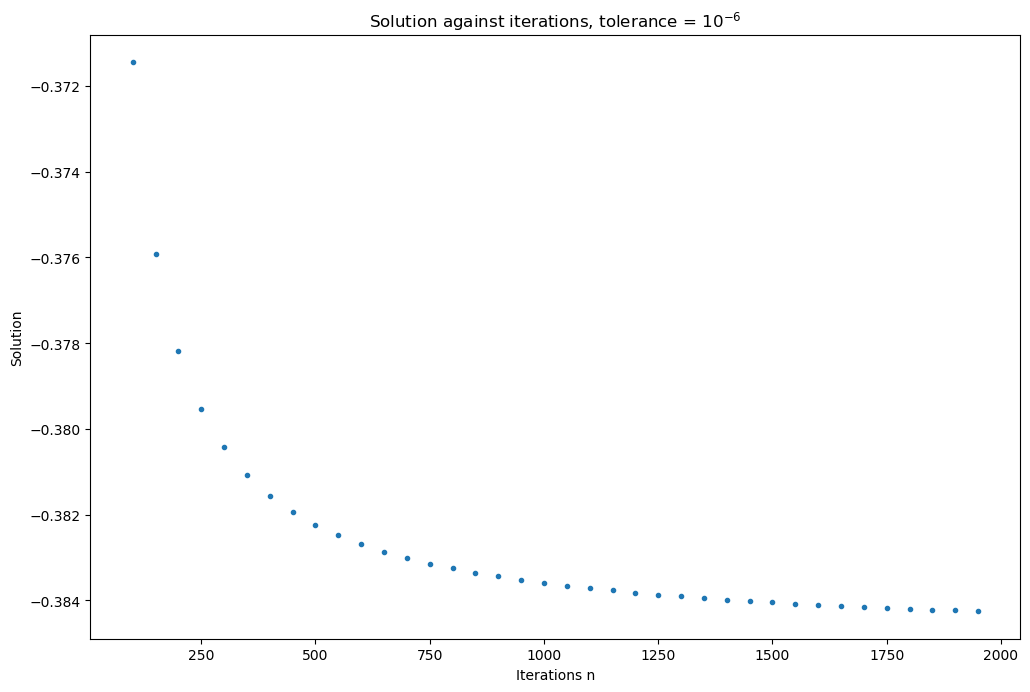

In [6]:
title("Solution against iterations, tolerance = $10^{-6}$")
ylabel("Solution")
xlabel("Iterations n")
plot(x, y, linestyle = " ", marker = ".") 

As you'll see later, this curve is not well approximated using an exponential decay, but it does plateau, which shows that it is converging on a solution. From the gradient of the curve, I wouldn't trust it past 3 decimal places at 2000 iterations, which would give an approximate solution of 0.310, which I would trust since it appears to be converging on a value that would round to 0.310 looking a the y axis. 

In [7]:
def tolerances(start, end, res, n):
    """
    This function returns a two lists one of time taken for each individual iteration, and the other is the value of the 
    approximate solution against the tolerance for the integral / ODE
    Inputs: start: starting power of 10
            end: end power of 10
            res: number of samples between powers
            n: fixed number of iterations
    Output: 3 lists, containing number of iterations against the corresponding solution and the time taken to get that solution"""
    out = [[],[],[]]
    tol = linspace(start, end, res).tolist()
    for i in tol:
        global tolerance
        tolerance = 10**-i
        T = 1
        dt = T/n
        t = linspace(0,T,n)
        out[0].append(i)
        start = timeit.default_timer()
        out[2].append(minimise(1,1.1, lambda x: trapesium((reverse_euler(x, fxt, dt, n)-zt(t))**2, dt), 0.1, tolerance))
        end = timeit.default_timer()
        out[1].append(end - start)
    return out[0], out[1], out[2]
x1,z1,y1 = tolerances(14, 4, 20, 1000)
print("Done\nRuntime = " + str(sum(z1)) + " s")

Done
Runtime = 3.2968340000000005 s


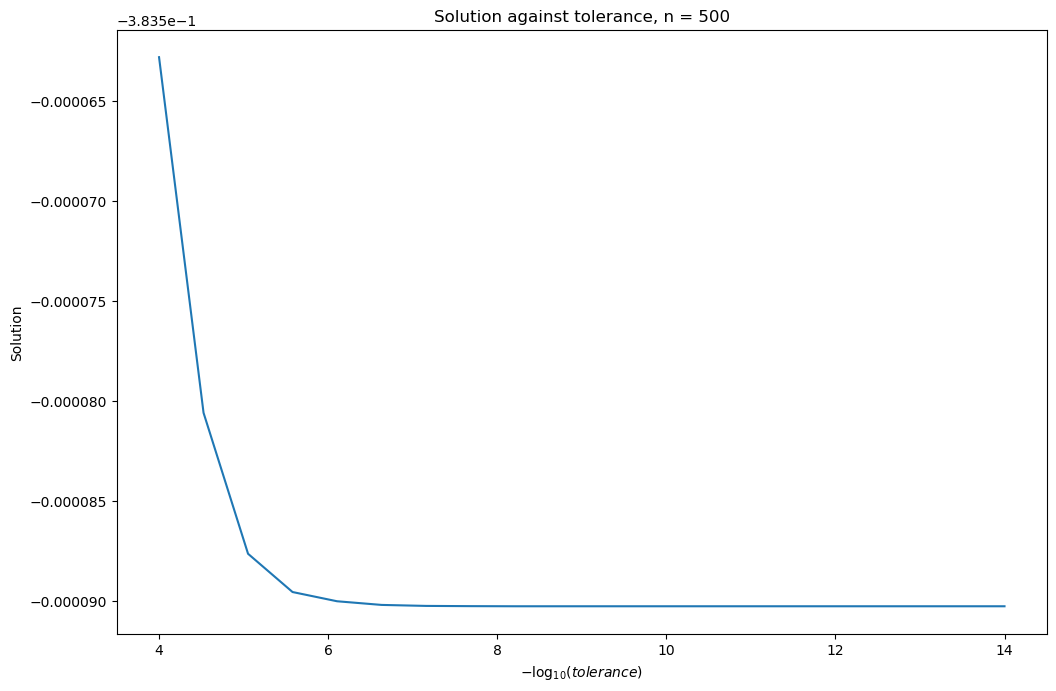

In [8]:
title("Solution against tolerance, n = 500")
ylabel("Solution")
xlabel("$-\log_{10}(tolerance)$")
plot(x1, y1)

The value of the solution plateaus at around $10^{-6}$ so going for higher tolerances will have littel effect on the solution, while lower tolerances will decrease accuracy greatly. That said, the vairation in the solution due to the tolerance is very small, varying in $10^{-6}$ which is much less than the variation of the solution due to the number of iterations, if you look above, that vaires in $10^{-4}$ from 1000 to 2000 iterations.

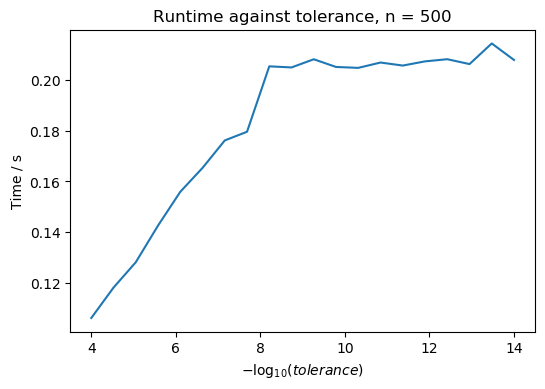

In [24]:
title("Runtime against tolerance, n = 500")
ylabel("Time / s")
xlabel("$-\log_{10}(tolerance)$")
plot(x1, z1)

Computation time increases linearly up to a tolerance of $10^{-8}$ then the gradient becomes more steep. From this, I would say that the ideal tolerance would be $10^{-6}$ as this is at the start of the plateu in the solution and it has $\frac{2}{3}$ the runtime of tolerances of $10^{-10}$ and below. That said, if I wanted to have a very high accuracy, then I would go with a tolerance of $10^{-14}$ as this has the same runtime as higher tolerances due to the plateau. Probing at a tolerance of 16 doesn't work probably because this would cause the gradient descent to oscillate about the root, making lambda smaller would resolve this issue.

Surface plot of solution against iterations and tolerance
-----------

In [26]:
def surface(tol0, tol1, n0, n1, res):
    """
    Inputs: tol0, tol1 the starting and ending tolerance range to be sampled
            n0, n1, resultion starting and ending resoltuion to be sampled over
            res: resolution of plot; res**2 = total number of points sampled
    Outputs:tolerances: List of tolerances over the input range with n = resolution points sampled
            ns: List of sampled resolutions with n points sampled = resolution. 
            out: 2 dimensional list of the solutions pertaining to each combination of tol and n
            times: 2 dimenstional list of the runtimes pertaining to each combination of tol and n
    """
    tolerances = linspace(tol0, tol1, res)
    ns = linspace(n0, n1, res)
    out = [[0 for j in range(res)] for i in range(res)]
    times = [[0 for j in range(res)] for i in range(res)] #the stack was giving me trouble with times = out[:]
    for i in range(res):
        global tolerance
        tolerance = 10**-tolerances[i]
        for j in range(res):
            dt = T/int(ns[j])
            n = int(ns[j])
            t = linspace(0,T,n)
            start = timeit.default_timer()
            out[j][i] = minimise(1,1.1, lambda x: trapesium((reverse_euler(x, fxt, dt, n)-zt(t))**2, dt), 0.1, tolerance)
            times[j][i] = (timeit.default_timer() - start)
    return tolerances, ns, out, times

xs, ys, zs, ts = surface(4, 10, 100, 2000, 31)
print("Done\nRuntime = " + str(sum(ts)/60) + " min")

Done
Runtime = 3.8462341149998567 min


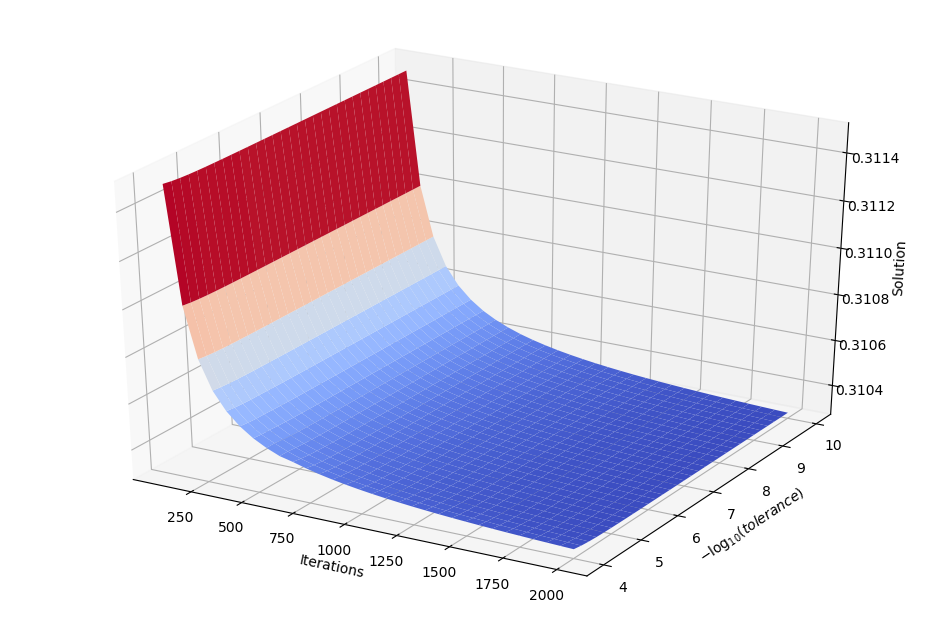

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
fig = plt.figure()
ax = fig.gca(projection='3d')
Y, X = meshgrid(xs, ys)
ax.set_xlabel('Iterations')
ax.set_ylabel('$-\log_{10}(tolerance)$')
ax.set_zlabel('Solution')
surf = ax.plot_surface(X, Y, array(zs), cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.show()

There is close to no change in the solution with varying the tolerance compared with iterations, meaning that going for a high tolerance really has diminishing returns compared with the roughly linear increase in runtime. The number of iterations on the other hand has a great effect int he value of the solution, therefore going for a higher number of iterations with a low tolerance may be the most efficient method. 

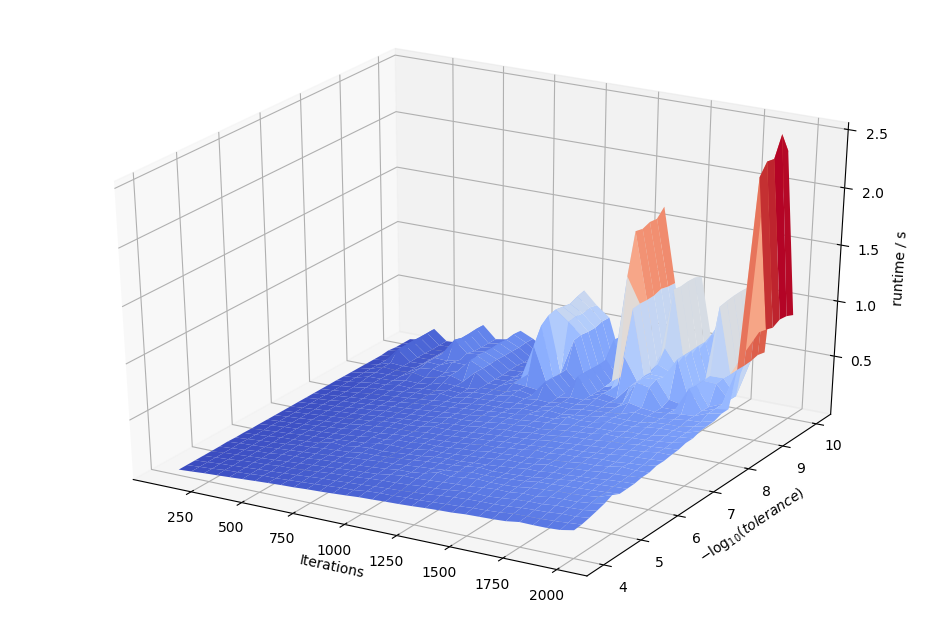

In [30]:
fig = plt.figure()
ax = fig.gca(projection='3d')
Y, X = meshgrid(xs, ys)
ax.set_xlabel('Iterations')
ax.set_ylabel('$-\log_{10}(tolerance)$')
ax.set_zlabel('runtime / s')

surf = ax.plot_surface(X, Y, array(ts), cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.show()

The runtime is roughtly linear in both iterations and tolerance until $-\log_{10}(tolerance)$ goes above 9, at which point there is a large increase in the runtime. Therefore I would keep my tolerance around 6 - 7 and then increase my iterations which will give a linear relationship with runtime in order to get a more accurate solution to the problem. 

Testing individual functions
-----------------

0.0666361136893059


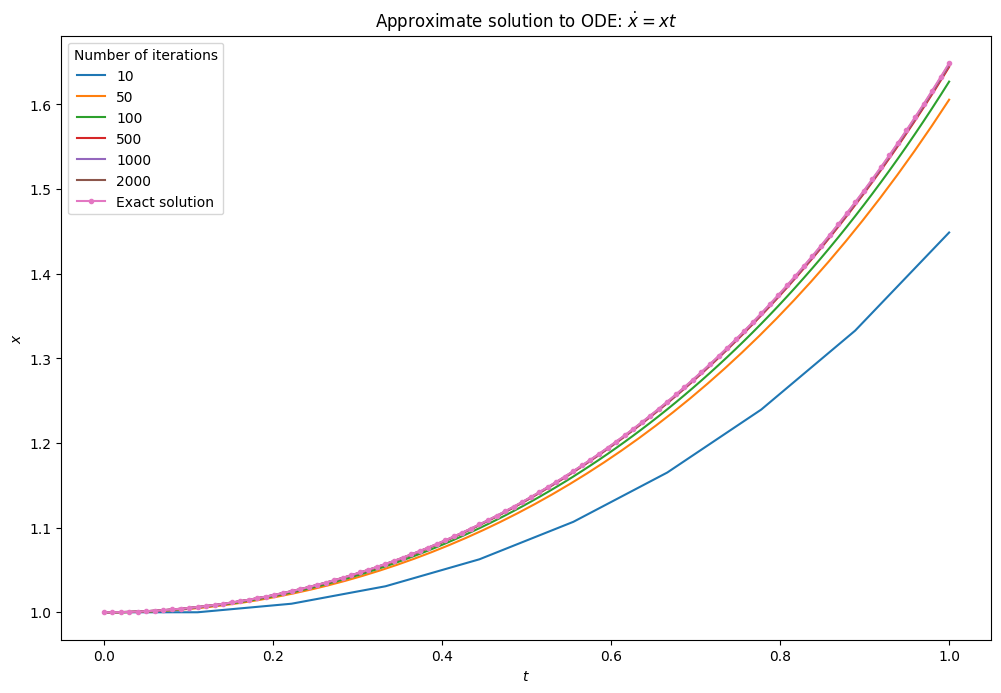

In [5]:
figure(figsize(12,8))
ns = [10, 50, 100, 500, 1000, 2000]
title("Approximate solution to ODE: $\dot x = xt$")
ylabel("$x$")
xlabel("$t$")
solutions = [plot(linspace(0,1,int(i)), reverse_euler(1, fxt, 1/i, int(i)), label = str(i)[:5]) for i in ns]#plotting approx solutions
plot(linspace(0,1,100), e**(0.5*linspace(0,1,100)**2), label = "Exact solution", marker = ".") #plotting exact solution
legend(title = "Number of iterations")
aprox = reverse_euler(1, fxt, 1/2000, 2000)[-1] #calculating error relative to the exact solution
ext = e**(0.5*linspace(0,1,100)**2)[-1]
print(100*(ext-aprox)/ext)

1000 plus iterations is giving a good approximation of the ODE, as the lines effectively overlap so there's less than 1 % error in the solution here, 0.07 % error to be exact.

0.33206350599085527

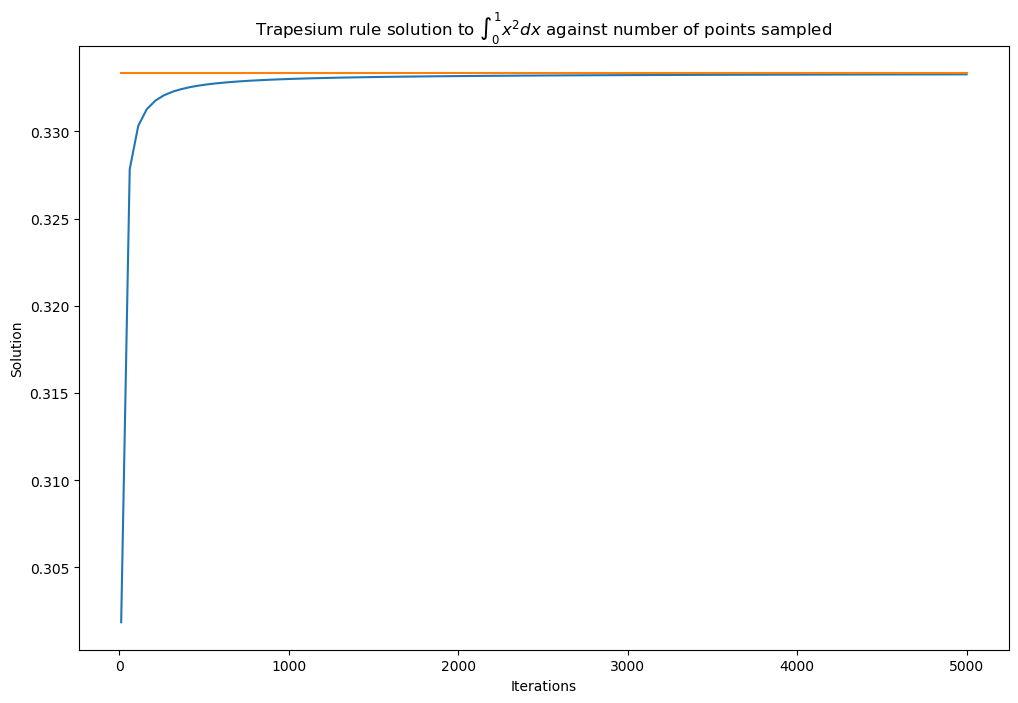

In [181]:
g = lambda x: x**2
def t(start, end, n):
    ns = linspace(start, end, n)
    return ns, [trapesium(g(linspace(0, 1, int(i))), 1/int(i))for i in ns]
x, y = t(10, 5000, 100)   
title("Trapesium rule solution to $\int_0^1x^2dx$ against number of points sampled")
ylabel("Solution")
xlabel("Iterations")
plot(x,y)
plot([x[0], x[-1]], [1/3, 1/3])
y[5]

The largest source of error in my solution appears to be the value of my integral approximated by my trapesium rule, at 1000 iterations, has a 0.4 % error compared with the exact solution of $\frac{1}{3}$, which means that I would only realy trust my final solution to $\pm 0.4 \%$ which would pertain to 3 decimal places, as is true of my solution from the plots above.
Conclusion
------
I think my code is reasonably well optimised; It's runtime isn't bad and I can get quite an accurate solution in a few seconds.

Ideal parameters for my test case:
<br>$Tolerance = 10^{-6}$
<br>$Iterations = 2000$ for accuracy $\approx 0.1\%$
<br>$Iterations = 20000$ for accuracy $\approx 0.01\%$
<br>$Lambda = 0.1$
<br>Runtime $\approx \frac{iterations}{10^4} s$ when toleracne = $10^{-6}$


Extra stuff
---------

(array([0.00105704, 0.00575921, 0.31033594]), array([[ 9.22470636e-10,  4.36492325e-09, -2.43280726e-11],
       [ 4.36492325e-09,  9.19709009e-08,  1.07253329e-09],
       [-2.43280726e-11,  1.07253329e-09,  5.55023675e-11]]))
0.0010570414041554555 0.00575921470559201 0.31033593500545836


C:\Users\franc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


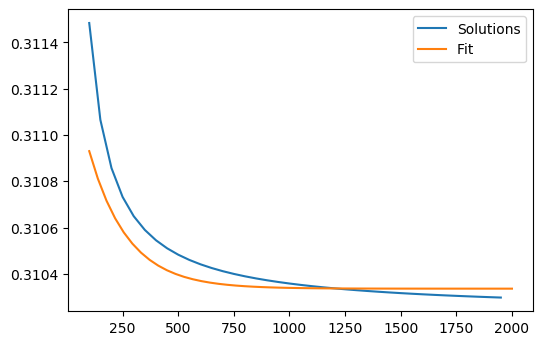

In [8]:
from scipy.optimize import curve_fit
function = lambda x, a, b, c: a*e**-(b*(x - 100)) + c
fit = curve_fit(function, x, y, p0 = [0.2254, y[0], 0.224])
print(fit)
plot(x,y, label = "Solutions")
a, b, c = fit[0][0], fit[0][1], fit[0][2]
#a, b, c = 0.00101736, 0.00591648, 0.22487
print(a,b,c)
plot(linspace(100, 2000, 50), a*e**(-linspace(100, 2000, 50)*b) + c, label = "Fit")
legend()

Doing a curve fit did not work to find the value that the curve converges to because as it turns out, this is not well described by an exponential decay, which is easily demonstrated by just taking logs of the y axis values and plotting, which doesn't give a straight line (which is would if it were well described by an exponential decay)

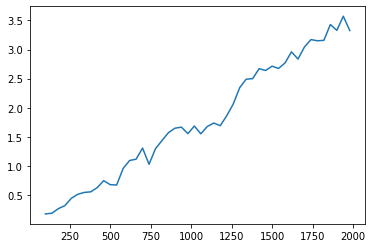

In [36]:
plot(x, z)


Running the code on my laptop gives a much less straight line for runtime against iterations because
the frequency on the cpu will vary a lot because it tries to use as little power as possible and it's only got 4 logical processors so other tasks will interfere.

(array([0.00106479, 0.31148388, 0.5       , 0.5       , 0.31041909]), array([[inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf]]))
0.0010647938611658399 0.31148388059733834 0.3104190867361703


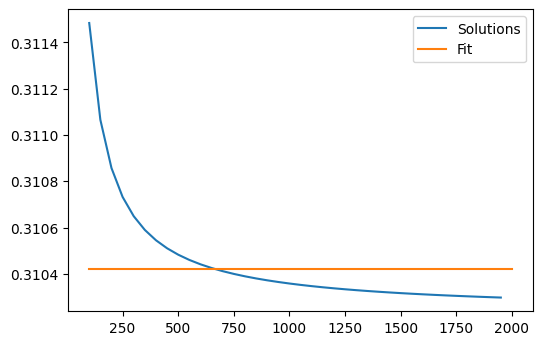

In [14]:
from scipy.optimize import curve_fit
function = lambda x, a, i, j, k, c: a*e**-(i*(x - 100) + j*(x - 100)**2 + k*(x - 100)**3) + c
fit = curve_fit(function, x, y, p0 = [0.3104, y[0], 0.5, 0.5, 0.3102])
print(fit)
plot(x,y, label = "Solutions")
a, i, j, k, c = fit[0][0], fit[0][1], fit[0][2], fit[0][3], fit[0][4]
#a, b, c = 0.00101736, 0.00591648, 0.22487
print(a,b,c)
xp = linspace(100, 2000, 50)

plot(xp, a*e**-(i*(xp) + j*(xp)**2 + k*(xp)**3) + c, label = "Fit")
legend()

This polynomial fit makes the exponential fit look good.....